In [1]:
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F 
import seaborn as sns
import numpy as np
import json
from tqdm import tqdm

In [2]:
def ElayerAvg(layer):
    filters=torch.tensor([[0,1,0],[1,0,1],[0,1,0]]).float().to('cuda').reshape(1,1,3,3)
    layerF=layer.float().to('cuda')
    layerShape=layerF.shape
    layerF=layerF.reshape(1,1,*layerShape)
    elayer=F.conv2d(layerF,filters,padding=0)
    layerF=layerF.reshape(*layerShape)
    elayer=elayer.squeeze(0).squeeze(0)
    return -(elayer*layerF[1:-1,1:-1]).mean()

### split by num of heads

In [3]:
def ensure_divisibility(numerator, denominator):
    """Ensure that numerator is divisible by the denominator."""
    assert numerator % denominator == 0, '{} is not divisible by {}'.format(
        numerator, denominator)


def divide(numerator, denominator):
    """Ensure that numerator is divisible by the denominator and return
    the division value."""
    ensure_divisibility(numerator, denominator)
    return numerator // denominator
def split_tensor_along_last_dim(tensor, num_partitions,
                                contiguous_split_chunks=False):
    """Split a tensor along its last dimension.
    Arguments:
        tensor: input tensor.
        num_partitions: number of partitions to split the tensor
        contiguous_split_chunks: If True, make each chunk contiguous
                                 in memory.
    """
    # Get the size and dimension.
    last_dim = tensor.dim() - 1
    last_dim_size = divide(tensor.size()[last_dim], num_partitions) # 得到每个切分的size
    # Split.
    tensor_list = torch.split(tensor, last_dim_size, dim=last_dim) # 对张量进行切分
    # Note: torch.split does not create contiguous tensors by default.
    if contiguous_split_chunks:
        return tuple(chunk.contiguous() for chunk in tensor_list)

    return tensor_list


In [4]:
def calculateEnergyMat(model,n_heads,weightName):
    Energy_Mat = []
    for i in range(n_heads):
        cur_layer_W_q = model["layers.{}.attention.{}.weight".format(str(i),weightName)]
        cur_heads = split_tensor_along_last_dim(cur_layer_W_q, n_heads)

        cur_energy = map(ElayerAvg ,list(cur_heads))
        Energy_Mat.append(list(cur_energy))
    return torch.tensor(Energy_Mat)

In [5]:
loadPTH='/data/shhliu19/wonder/llama/7B'
model=torch.load(loadPTH+'/consolidated.00.pth')
with open(loadPTH+'/params.json', 'r') as f:
    params = json.load(f)
n_head=params['n_heads']
cur_dim = params['dim']
assert(cur_dim%n_head==0)
world_size = cur_dim//n_head

In [6]:
def plotEnergyMat(model,n_hands):
    sns.set_context({"figure.figsize":(16,16)})
    plt.subplot(2, 2, 1)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wq'),square=True,vmax=5e-5,vmin= -5e-5)
    plt.subplot(2, 2, 2)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wk'),square=True,vmax=5e-5,vmin= -5e-5)
    plt.subplot(2, 2, 3)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wv'),square=True,vmax=1e-5,vmin= -1e-5)
    plt.subplot(2, 2, 4)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wo'),square=True,vmax=2e-5,vmin= -2e-5)

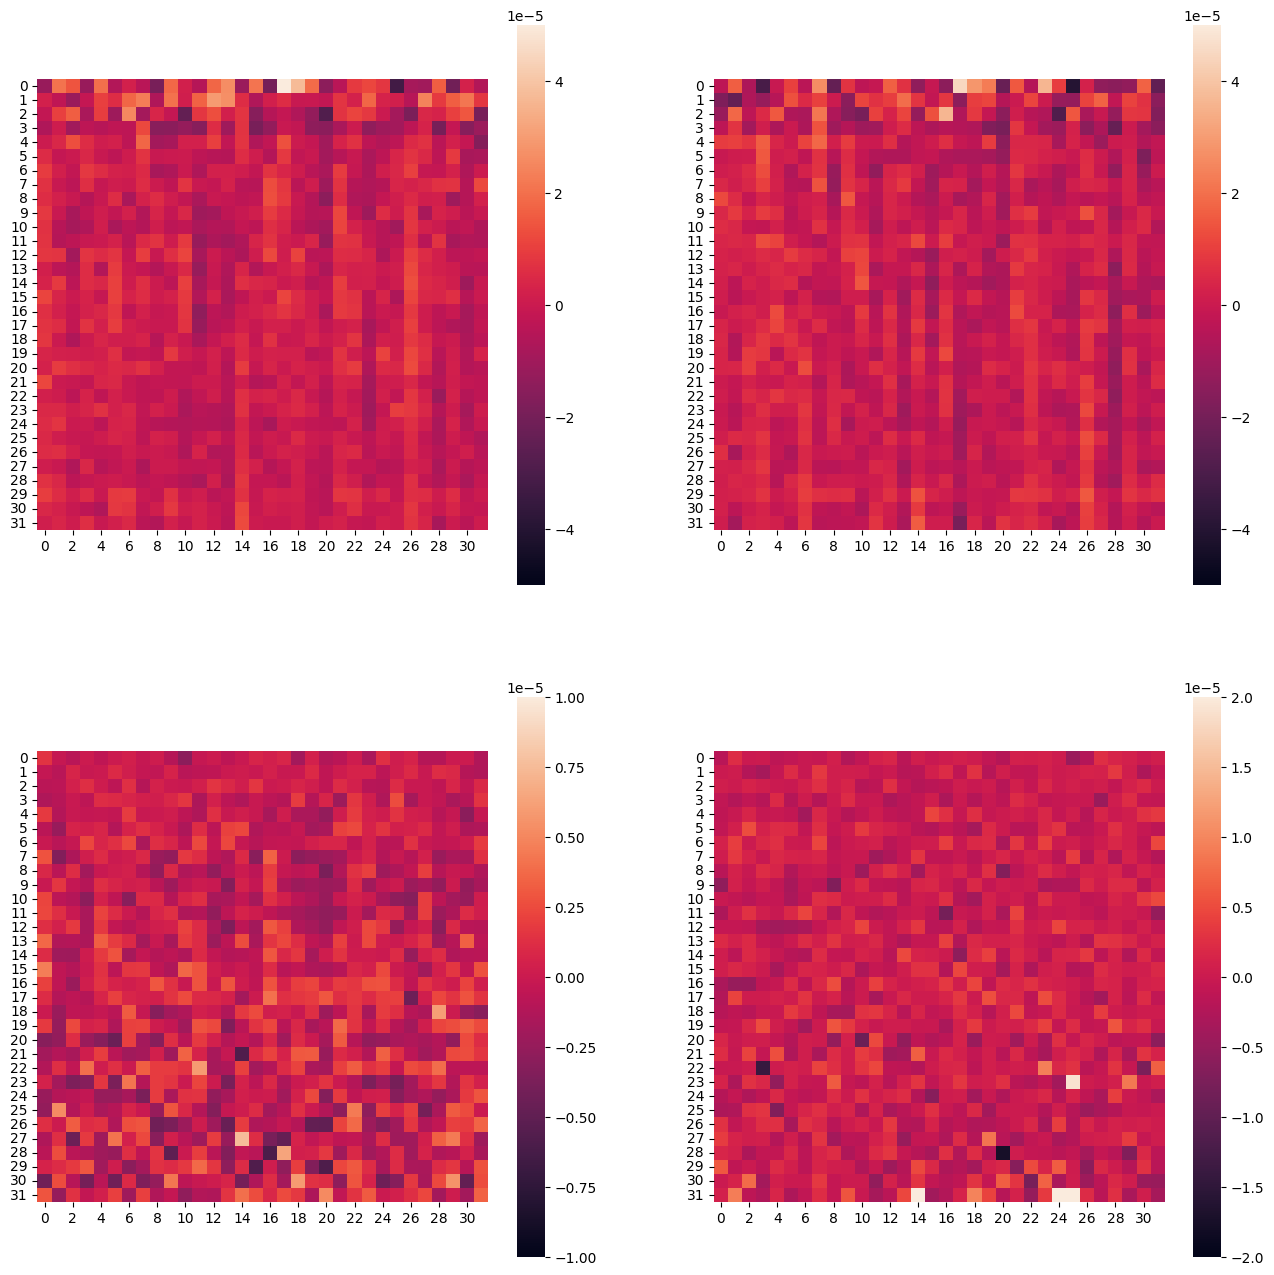

In [7]:
loadPTH='/data/shhliu19/wonder/llama/7B'
model=torch.load(loadPTH+'/consolidated.00.pth')
with open(loadPTH+'/params.json', 'r') as f:
    params = json.load(f)
n_heads=params['n_heads']
plotEnergyMat(model,n_heads)

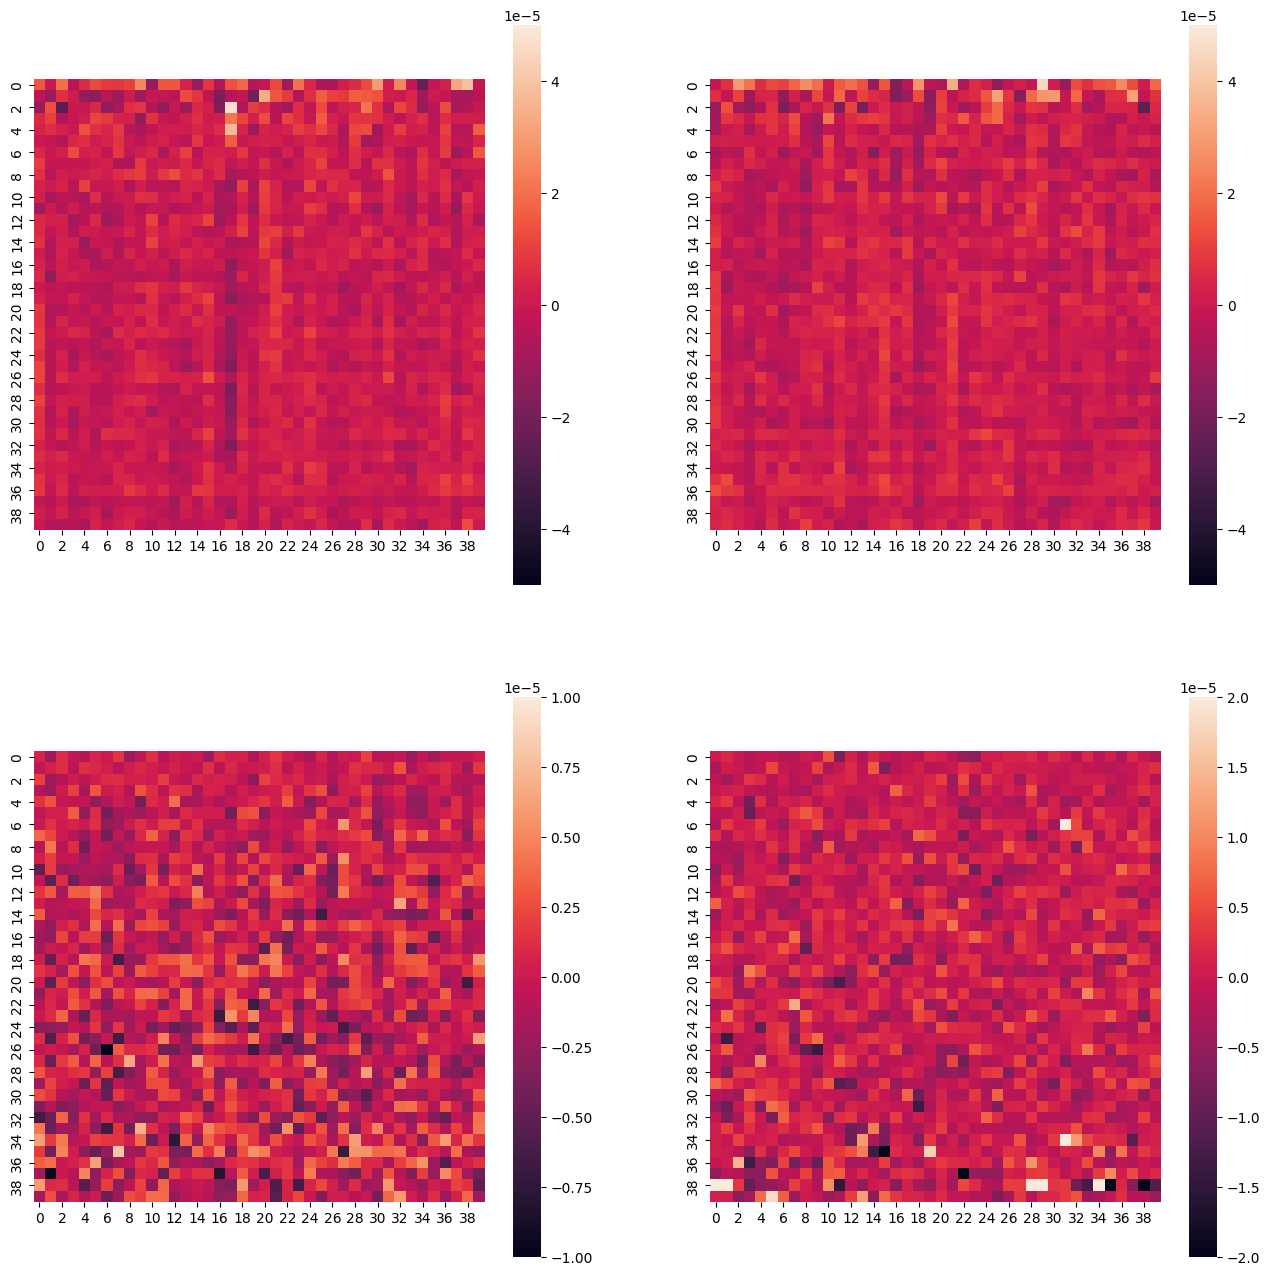

In [8]:
loadPTH='/data/shhliu19/wonder/llama/13B'
model=torch.load(loadPTH+'/consolidated.00.pth')
with open(loadPTH+'/params.json', 'r') as f:
    params = json.load(f)
n_heads=params['n_heads']
plotEnergyMat(model,n_heads)

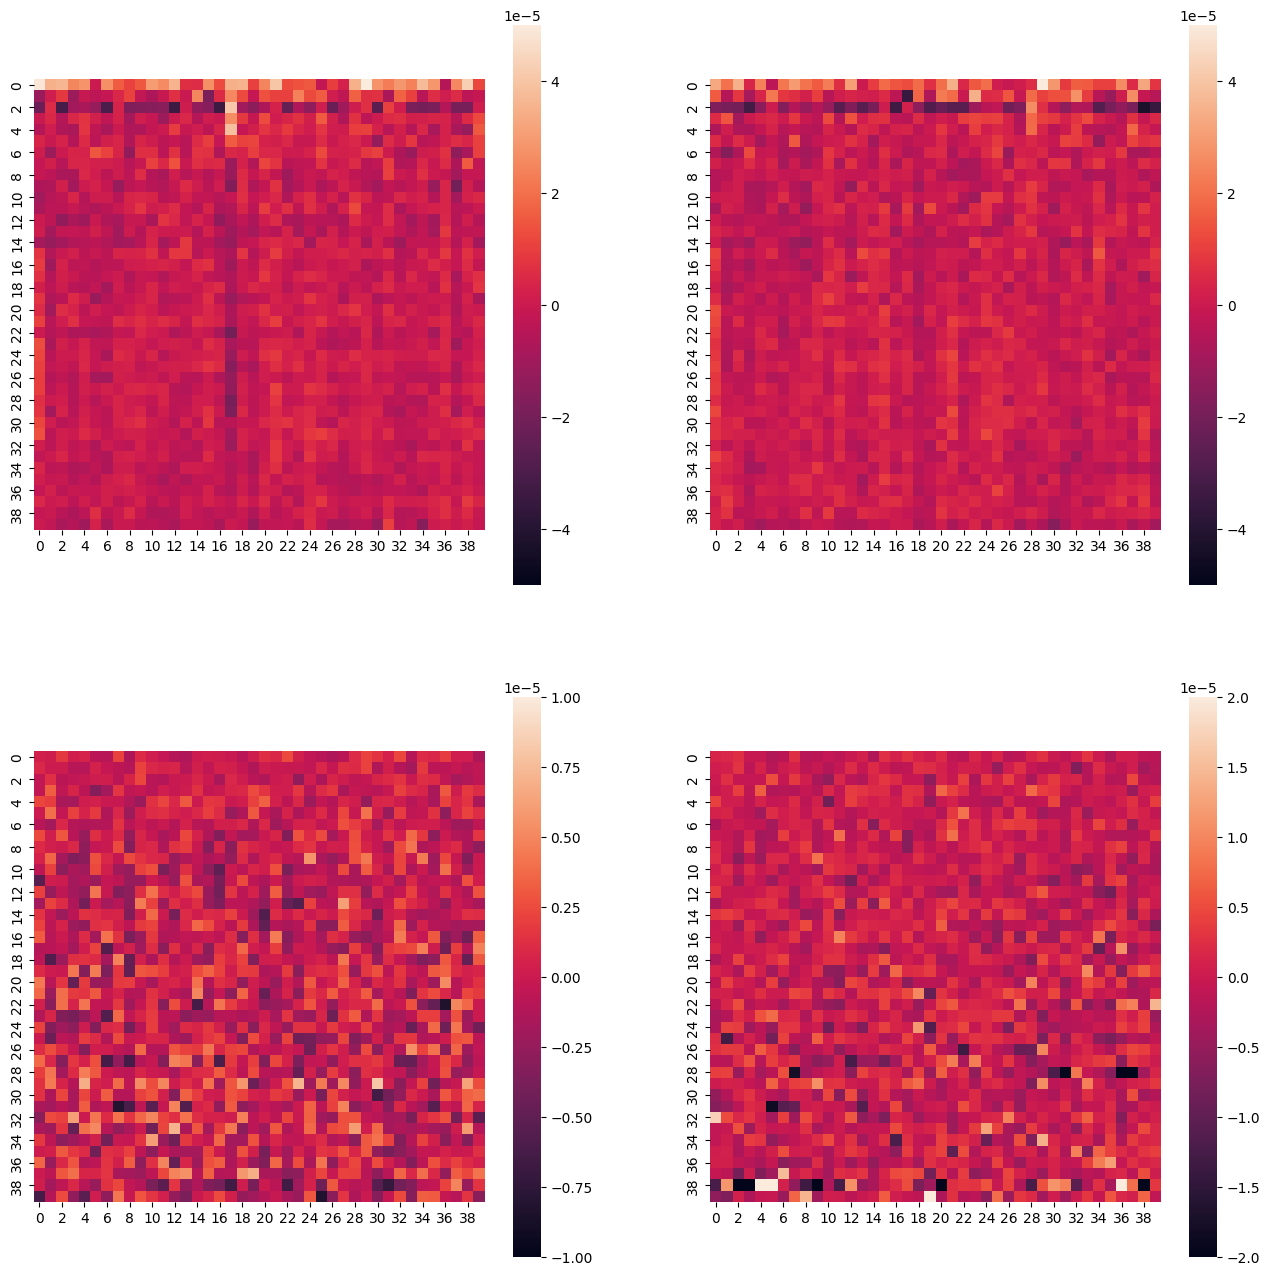

In [9]:
loadPTH='/data/shhliu19/wonder/llama/13B'
model=torch.load(loadPTH+'/consolidated.01.pth')
with open(loadPTH+'/params.json', 'r') as f:
    params = json.load(f)
n_heads=params['n_heads']
plotEnergyMat(model,n_heads)

In [10]:
loadPTH='/data/shhliu19/wonder/llama/65B'
with open(loadPTH+'/params.json', 'r') as f:
    params = json.load(f)
n_heads=params['n_heads']
n_layers=params['n_layers']

  0%|                                                                                             | 0/8 [00:16<?, ?it/s]


PermissionError: [Errno 13] Permission denied: '/home/shhliu19/wonder/fig/65BEnergyMat/consolidated.00.png'

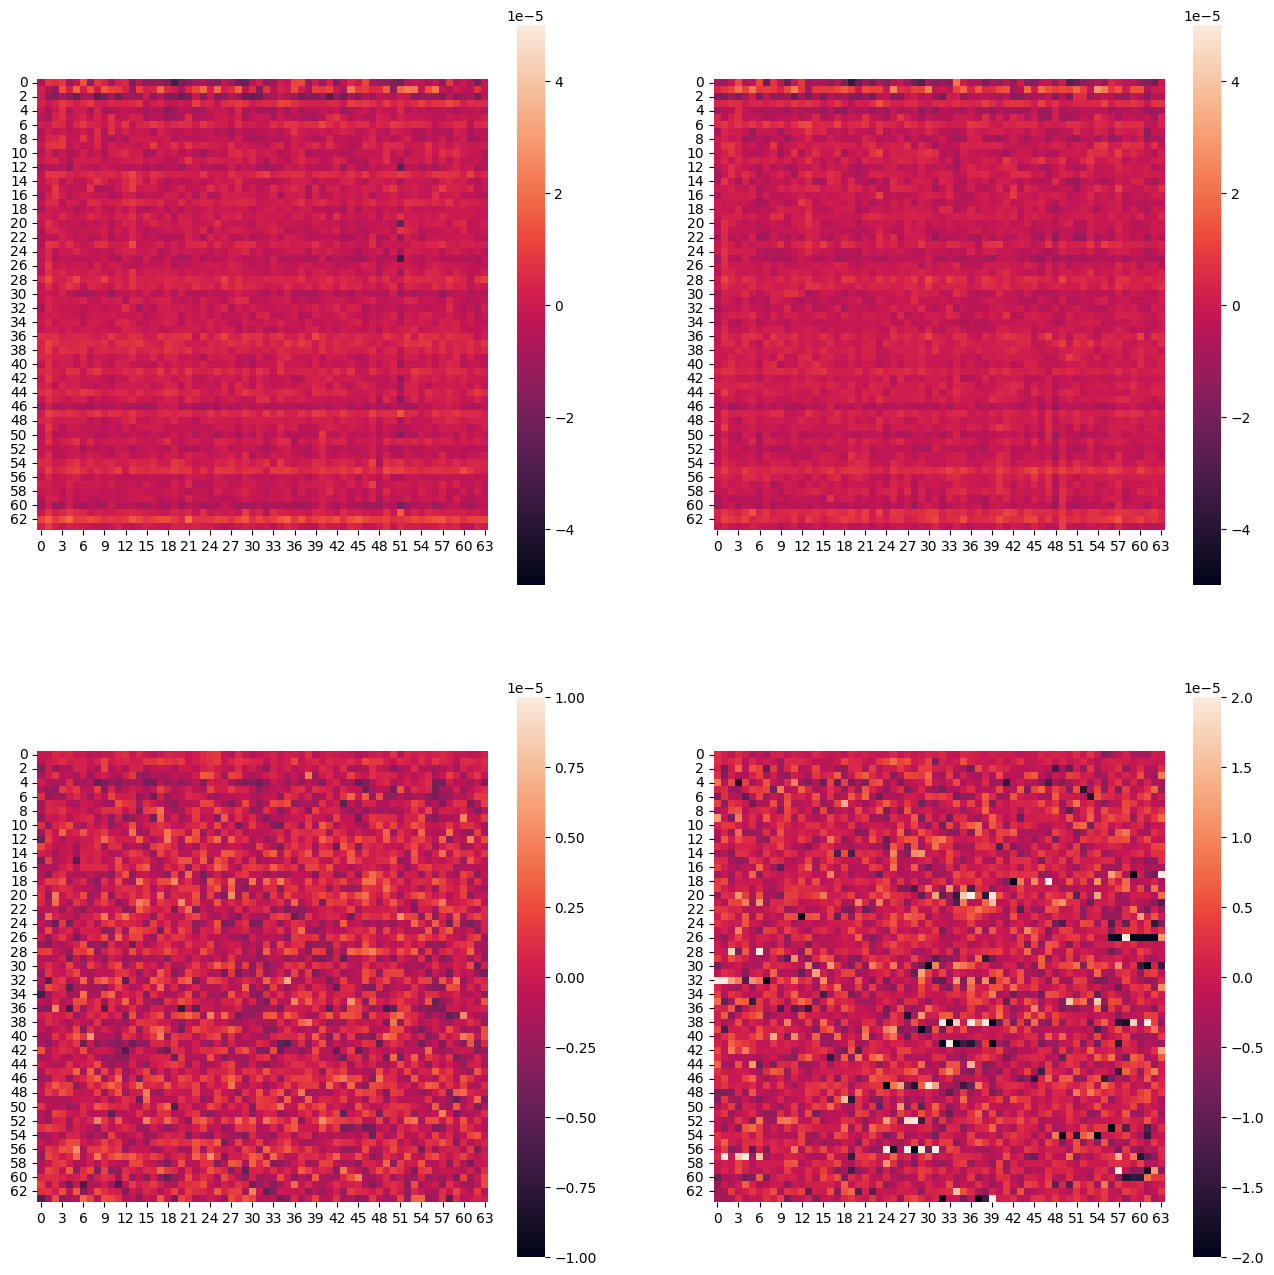

In [11]:
figPath='/home/shhliu19/wonder/fig/65BEnergyMat'
for i in tqdm(range(8)):
    model=torch.load(loadPTH+f'/consolidated.0{i}.pth')
    plotEnergyMat(model,n_heads)
    plt.savefig(figPath+f'/consolidated.0{i}.png',dpi=1000)

In [12]:
loadPTH='/data/shhliu19/wonder/llama/65B'
with open(loadPTH+'/params.json', 'r') as f:
    params = json.load(f)
n_heads=params['n_heads']
n_layers=params['n_layers']
print(n_heads)
print(n_layers)

64
80


In [13]:
def plotEnergyMat(model,n_hands):
    sns.set_context({"figure.figsize":(16,16)})
    plt.subplot(2, 2, 1)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wq'),square=True,vmax=5e-5,vmin= -5e-5)
    plt.subplot(2, 2, 2)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wk'),square=True,vmax=5e-5,vmin= -5e-5)
    plt.subplot(2, 2, 3)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wv'),square=True,vmax=1e-5,vmin= -1e-5)
    plt.subplot(2, 2, 4)
    sns.heatmap(data=calculateEnergyMat(model,n_heads,'wo'),square=True,vmax=2e-5,vmin= -2e-5)
def calculateEnergyMat_65B(model,n_layers,n_heads,weightName):
    Energy_Mat = []
    for i in range(n_layers):
        cur_layer_W_q = model["layers.{}.attention.{}.weight".format(str(i),weightName)]
        cur_heads = split_tensor_along_last_dim(cur_layer_W_q, n_heads)
        cur_energy = map(ElayerAvg ,list(cur_heads))
        Energy_Mat.append(list(cur_energy))
    return torch.tensor(Energy_Mat)

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:43<00:00, 27.94s/it]


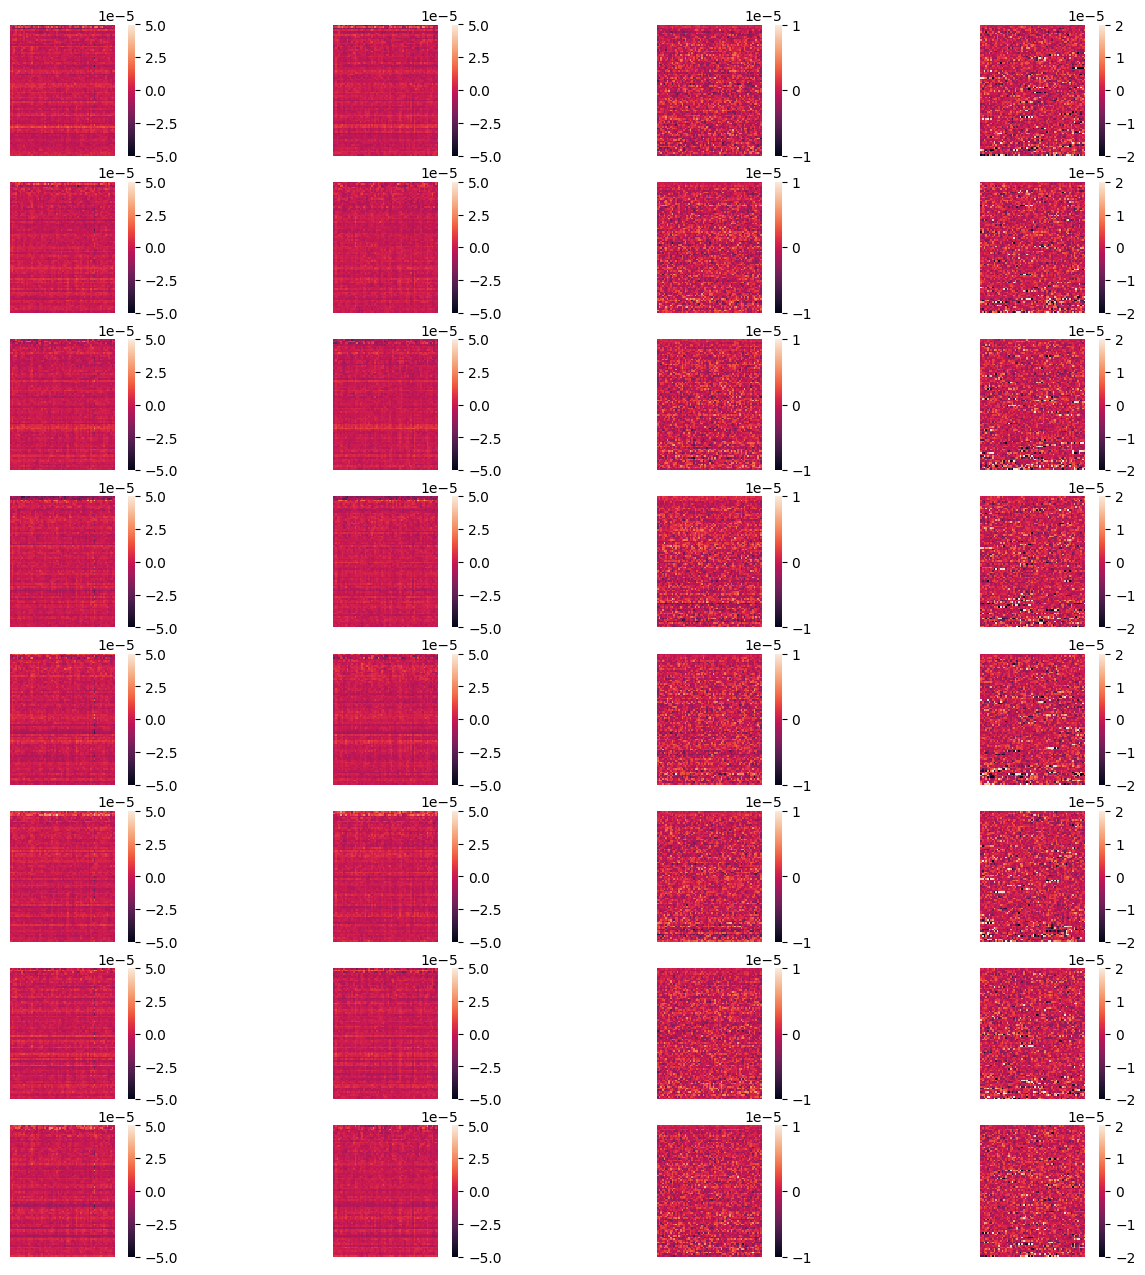

In [14]:
sns.set_context({"figure.figsize":(16,16)})
for i in tqdm(range(8)):
    model=torch.load(loadPTH+f'/consolidated.0{i}.pth')
    for j,item in enumerate(['wq','wk','wv','wo']):
        plt.subplot(8,4,j+1+4*i)
        if item == "wq":
            ax = sns.heatmap(data=calculateEnergyMat_65B(model, n_layers, n_heads, item), square=True,vmax=5e-5,vmin= -5e-5)
        elif item == "wk":
            ax = sns.heatmap(data=calculateEnergyMat_65B(model, n_layers, n_heads, item), square=True,vmax=5e-5,vmin= -5e-5)
        elif item == "wv":
            ax = sns.heatmap(data=calculateEnergyMat_65B(model, n_layers, n_heads, item), square=True,vmax=1e-5,vmin= -1e-5)
        else:
            ax = sns.heatmap(data=calculateEnergyMat_65B(model, n_layers, n_heads, item), square=True,vmax=2e-5,vmin= -2e-5)
        ax.tick_params(left=False, bottom=False)
        plt.axis('off')
        ax.axis('off')
plt.savefig('65B.pdf',dpi=1000)